# California housing

In [90]:
from sklearn.datasets import fetch_california_housing

# Load the dataset
housing = fetch_california_housing(as_frame=True)

# Access the features (X) and target (y)
df = housing.frame
print(df.head())

   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  


In [91]:
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010


1. Controllare che min e max abbiano senso (AveRooms e AveOccupationm fuori scala)
2. Rapporto tra media e dev std. Se è >1 forte dispersione di dati (AveOccup e Population)
3. Media e Mediana (50% percentile) sono simili tra di loro. Se non lo sono la distribuzione è skewed (asimmetrica) (se media << 50% applico una trasformazione logaritmica per bilanciare). 


In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


1. controllare le colonne che hanno dei null
2. controllare le colonne che non sono numeri, perchè la matematica non sa gestire le stringhe

## Gestione valori nulli

- se nulli < 5% rimuovo righe nulle
- se nulli < 15/20% sostituisco con media i numeri e moda le stringhe
- se nulli > 20% o elimino la colonna o creo un modello di ML per predirre i nulli

### Sostituzione con media
Immaginiamo un dataset con età e guadagno, ho il 10% dei  nulli su guadagno
Raggruppo in fasce d'età e faccio la media di ogni fascia, sostituisco i nulli del guadagno in base all'età associata.


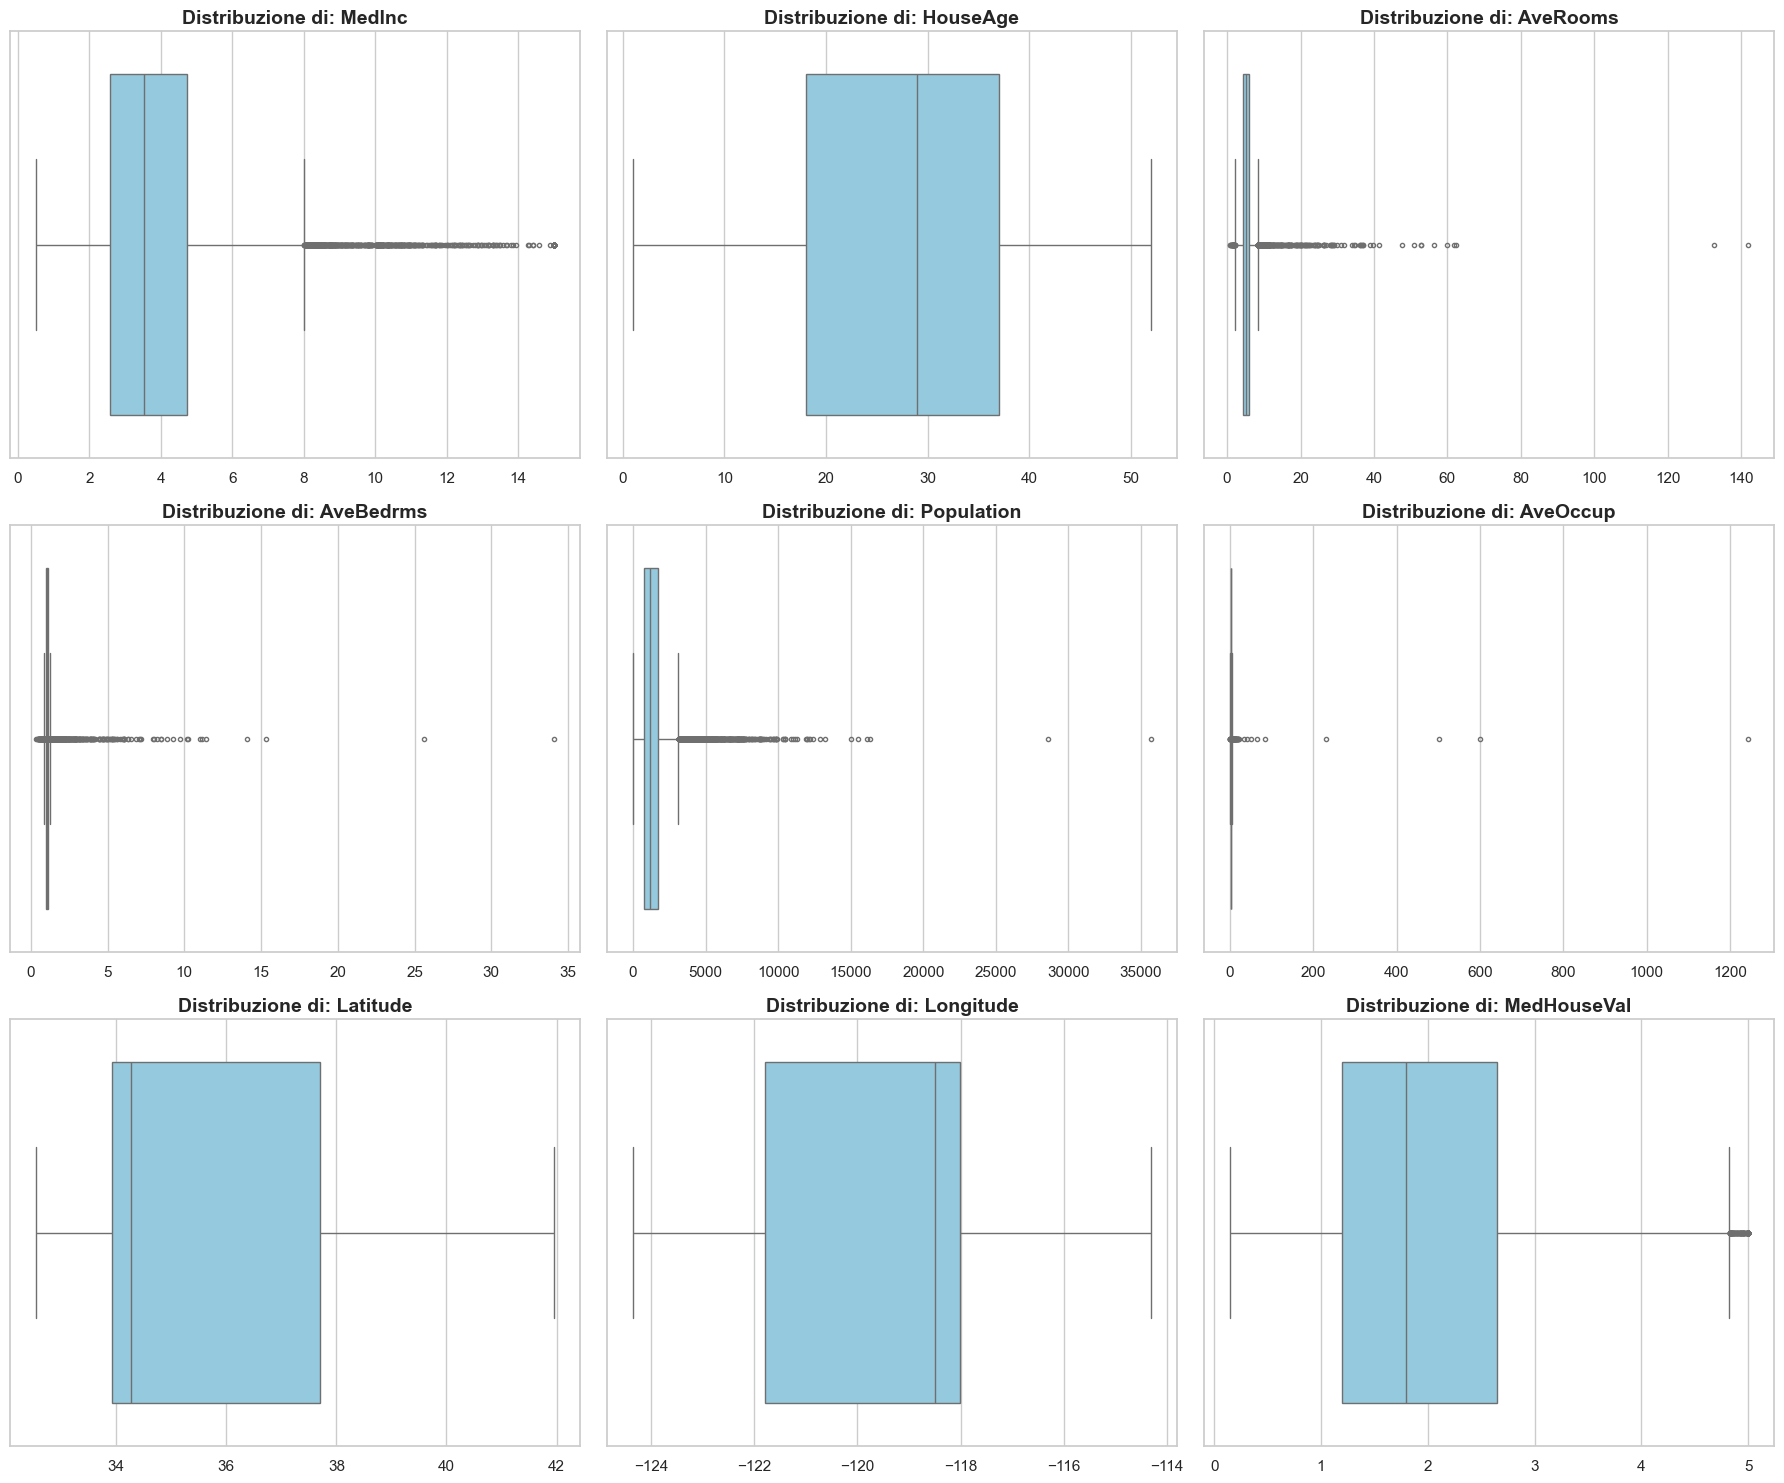

In [93]:
import seaborn as sns
import matplotlib.pyplot as plt
# 2. Impostiamo lo stile e la griglia
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten() # Appiattiamo la matrice di assi per iterare facilmente

# 3. Ciclo per creare un boxplot per ogni colonna
for i, col in enumerate(df.columns):
    sns.boxplot(x=df[col], ax=axes[i], color='skyblue', fliersize=3)
    axes[i].set_title(f'Distribuzione di: {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('') # Rimuoviamo l'etichetta x per pulizia

# 4. Ottimizzazione del layout
plt.tight_layout()
plt.show()

Q1 (primo quartile) → 25% dei dati è sotto questo valore
Q2 (secondo quartile) → è la mediana (50% dei dati sotto)
Q3 (terzo quartile) → 75% dei dati è sotto questo valore

### cosa rappresentano le linee verticali del boxplot?
- Le linee verticali rappresentano i valori minimi e massimi (non anomali) dei dati in ogni colonna.
- e la parte blu del boxplot?
- La parte blu del boxplot rappresenta l'intervallo interquartile (IQR), quindi il 50% centrale dei dati.
- La linea all'interno del box rappresenta la mediana.
- I pallini sono i nostri outliers




## Outliers
Gli outliears possono essere di due tipi:
- caso statisticamente raro, es persona alta 2,30 m
- errore di inserimento, es persona alta 23 m

### 1. Metodo IQR (Interquartile Range)

È la tecnica usata dai **boxplot**. Si basa sulla distanza tra il primo quartile ($Q_1$) e il terzo quartile ($Q_3$). Tutto ciò che cade fuori dall'intervallo $[Q_1 - 1.5 \times IQR, Q_3 + 1.5 \times IQR]$ viene considerato outlier.

In [94]:
def remove_outliers_iqr(data, columns):
    df_clean = data.copy()
    for col in columns:
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filtraggio
    df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
    return df_clean

# Applichiamolo solo ad alcune colonne critiche (es. MedInc e AveRooms)
df_iqr = remove_outliers_iqr(df, ['MedInc', 'AveRooms', 'AveOccup'])
print(f"Righe rimosse con IQR: {len(df) - len(df_iqr)}")



Righe rimosse con IQR: 711


### 2. Metodo Z-Score (Deviazione Standard)

Questa tecnica si basa sulla distribuzione normale. Si calcola quanto un valore dista dalla media in termini di deviazioni standard ($\sigma$). La formula dello Z-score è:

$$Z = \frac{x - \mu}{\sigma}$$

Solitamente, un valore con uno **Z-score maggiore di 3 o minore di -3** è considerato un outlier estremo (rappresenta meno dello 0.3% dei dati in una distribuzione normale).

In [95]:
import numpy as np
from scipy import stats

def remove_outliers_zscore(data, columns, threshold=3):
    df_clean = data.copy()
    # Calcoliamo lo Z-score assoluto per ogni colonna selezionata
    z_scores = np.abs(stats.zscore(df_clean[columns]))

    # Teniamo solo le righe dove TUTTE le colonne hanno Z < threshold
    filtered_entries = (z_scores < threshold).all(axis=1)
    return df_clean[filtered_entries]

# Applicazione
df_zscore = remove_outliers_zscore(df, ['MedInc', 'AveRooms', 'AveOccup'])
print(f"Righe rimosse con Z-Score: {len(df) - len(df_zscore)}")

Righe rimosse con Z-Score: 482


IQR è più aggressivo ma funziona bene con distribuzioni più sporche
z-score meno aggressivo ma funziona solo su dati distribuiti normalmente


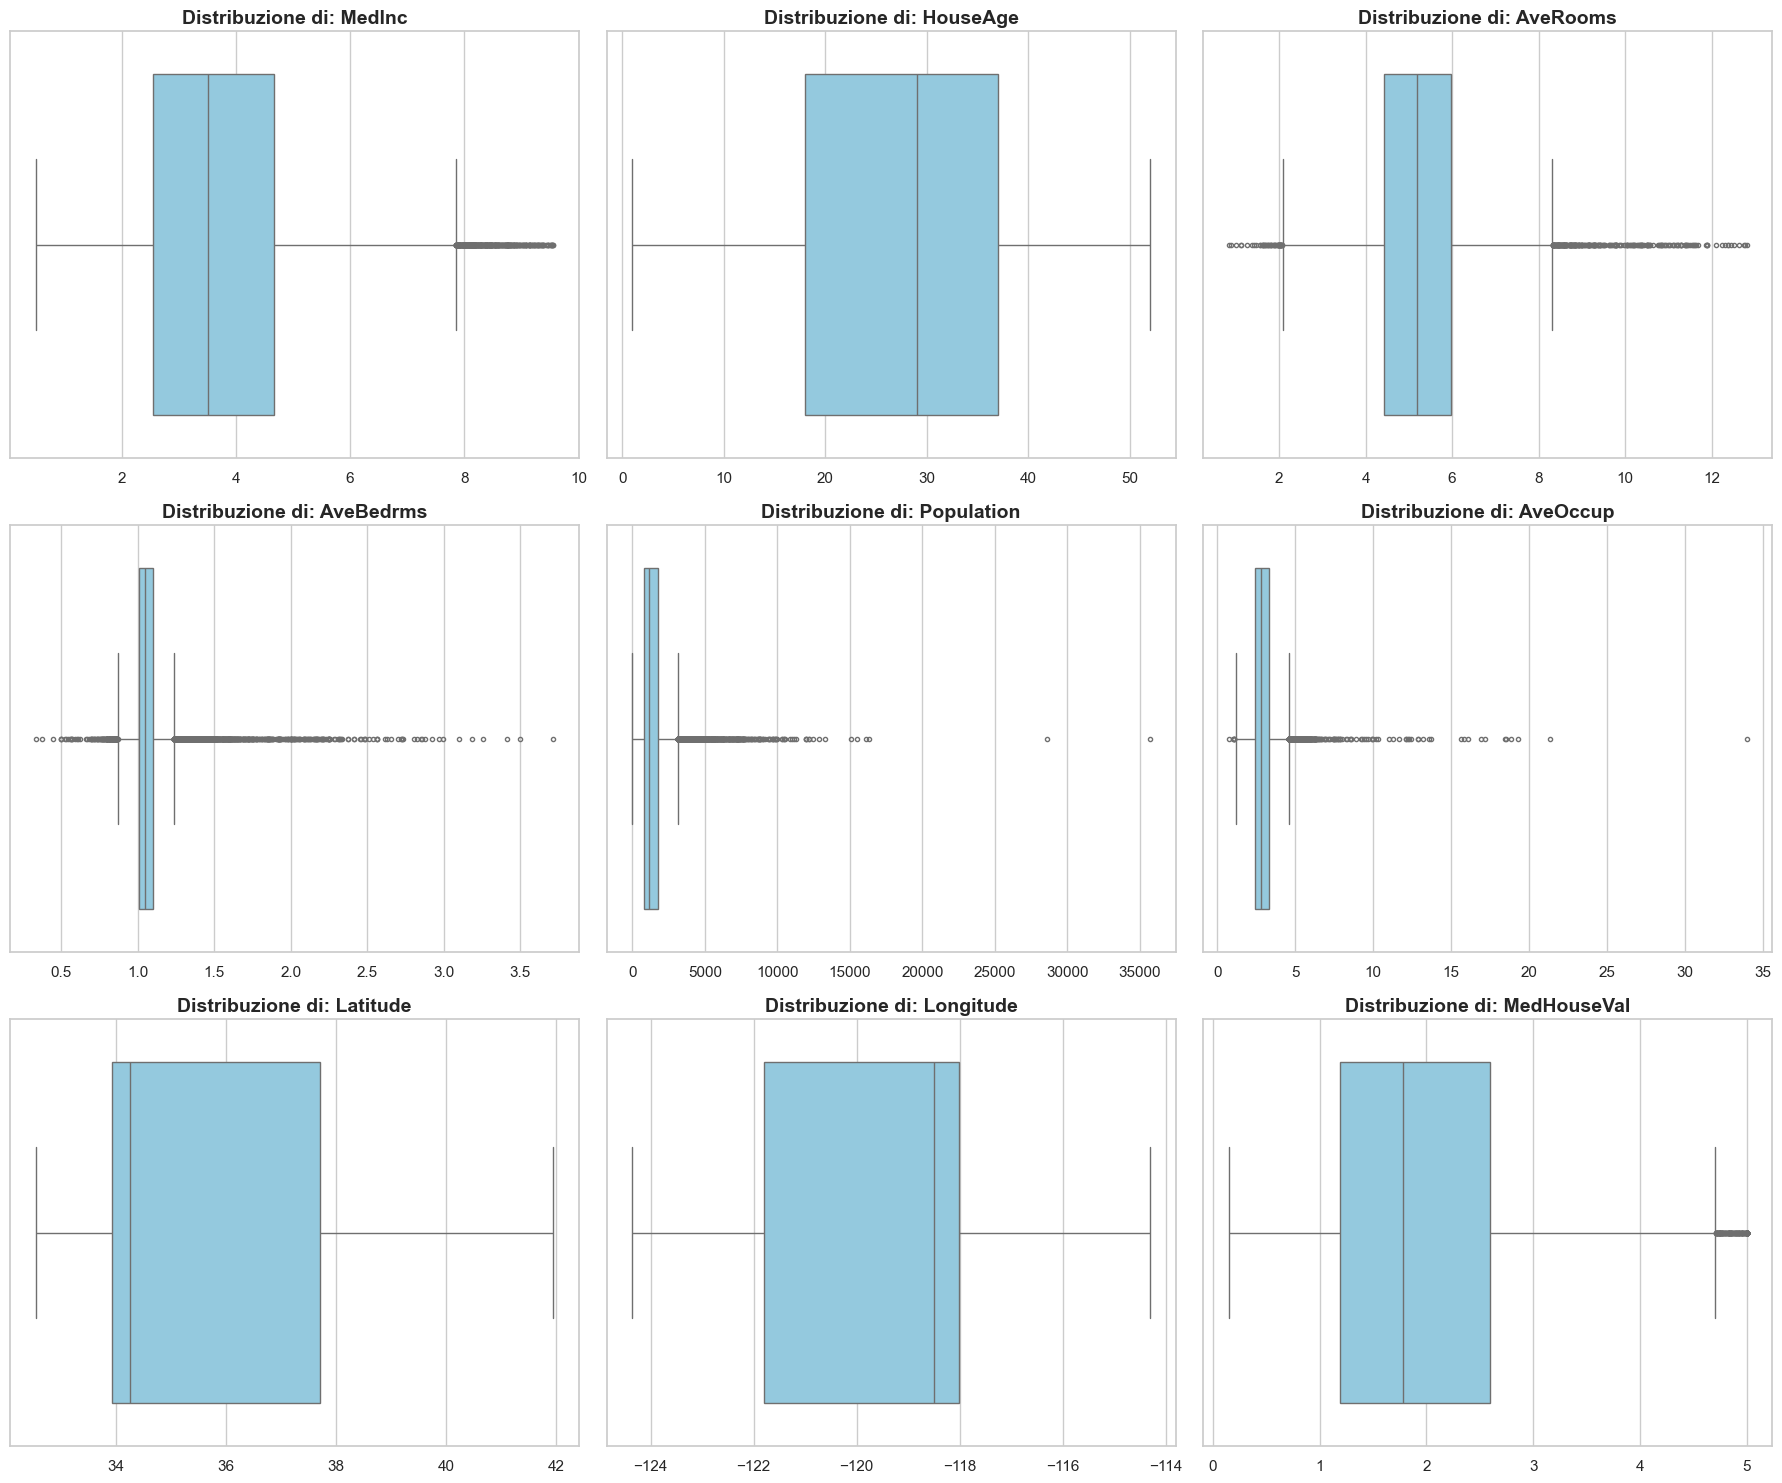

In [96]:
# 2. Impostiamo lo stile e la griglia
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 15))
axes = axes.flatten() # Appiattiamo la matrice di assi per iterare facilmente

# 3. Ciclo per creare un boxplot per ogni colonna
for i, col in enumerate(df_zscore.columns):
    sns.boxplot(x=df_zscore[col], ax=axes[i], color='skyblue', fliersize=3)
    axes[i].set_title(f'Distribuzione di: {col}', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('') # Rimuoviamo l'etichetta x per pulizia

# 4. Ottimizzazione del layout
plt.tight_layout()
plt.show()

## Colonne categoriche

Se la colonna è binaria (True/False) la trasformiamo in 0/1

Se ho più variabili, tipo (Milano, Roma, Napoli) assegno ad ogni variabile un numero (Milano=1 Roma=2 Napoli=3). 

Qui sorge un problema: con la nuova configurazione per il computer milano+roma=napoli non posso quindi applicarla su variabili scollegate. 

Se avessi piccolo-media-grande che hanno un rapporto di grandezza potrei farlo ma se sono scollegate devo procedere diversamente.

Creo una colonna binaria per ogni opzione: 
nuova colonna: is_Milano che contiene True o False ossia 0/1, is_Roma, is_Napoli  (attenzione che se ho 100 opzioni sto aggiungendo 100 dimensioni)



### 1. Label Encoding

Il `LabelEncoder` trasforma le stringhe in numeri progressivi ($0, 1, 2, ...$).

In [97]:
from sklearn.preprocessing import LabelEncoder

# Esempio: Target con tre classi
y = ['Basso', 'Medio', 'Alto', 'Basso', 'Alto']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Classi originali: {le.classes_}")
print(f"Valori trasformati: {y_encoded}")
# Output: [1, 2, 0, 1, 0] (l'ordine è spesso alfabetico)

Classi originali: ['Alto' 'Basso' 'Medio']
Valori trasformati: [1 2 0 1 0]


### 2. One-Hot Encoding

Questa è la tecnica standard per le variabili categoriche senza un ordine intrinseco (es. "Colore", "Città"). Crea una nuova colonna binaria ($0$ o $1$) per ogni categoria.

In [98]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# DataFrame di esempio
df_test = pd.DataFrame({'Città': ['Roma', 'Milano', 'Napoli', 'Roma']})

# Inizializziamo l'encoder
# sparse_output=False serve per avere un array NumPy leggibile (non una matrice sparsa)
ohe = OneHotEncoder(sparse_output=False)

# Trasformazione
ohe_transformed = ohe.fit_transform(df_test[['Città']])

# Creiamo un nuovo DataFrame con i nomi delle colonne corretti
df_ohe = pd.DataFrame(ohe_transformed, columns=ohe.get_feature_names_out(['Città']))

print(df_ohe)


   Città_Milano  Città_Napoli  Città_Roma
0           0.0           0.0         1.0
1           1.0           0.0         0.0
2           0.0           1.0         0.0
3           0.0           0.0         1.0


## Visualizziamo le distribuzioni delle colonne

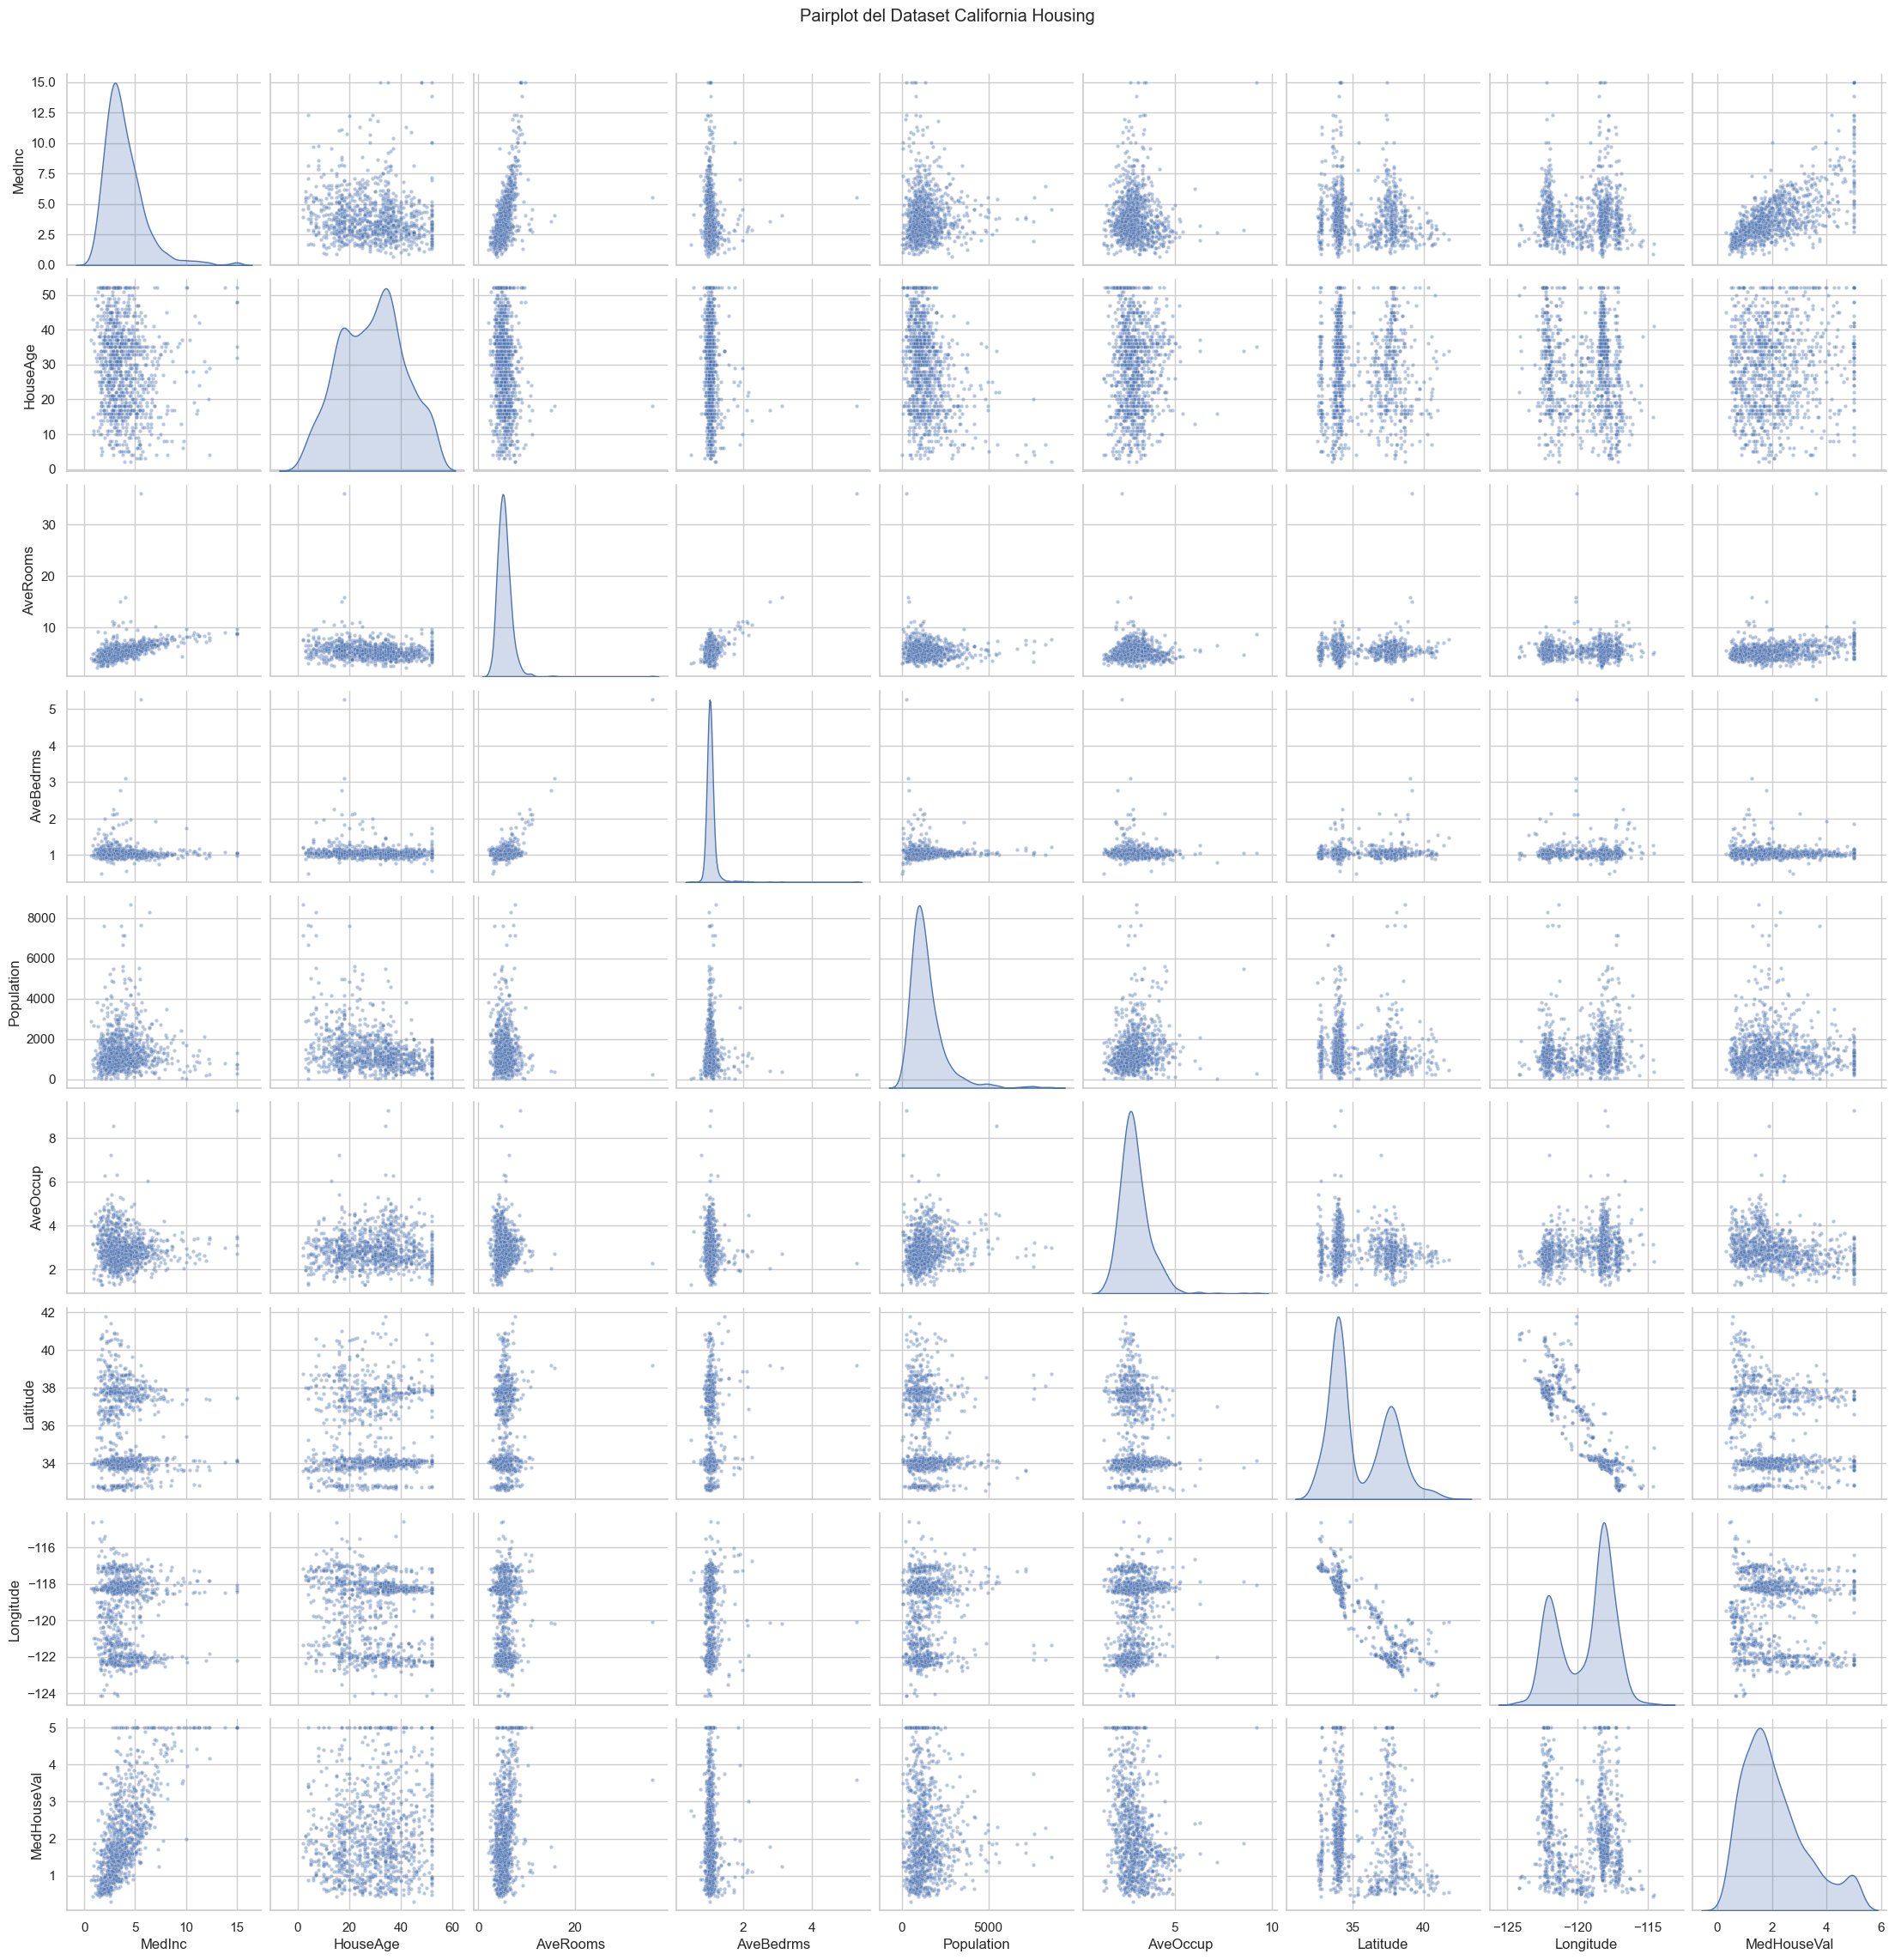

In [99]:
# Campionamento per velocità e chiarezza (es. 1000 righe)
df_sample = df.sample(n=1000, random_state=42)

# Creazione del Pairplot
# 'diag_kind' imposta i grafici sulla diagonale (istogrammi o densità KDE)
# 'plot_kws' serve per rimpicciolire i punti e renderli trasparenti
sns.pairplot(df_sample,
diag_kind='kde',
plot_kws={'alpha': 0.4, 's': 10})

plt.suptitle("Pairplot del Dataset California Housing", y=1.02)
plt.show()

guradare se sulla diagonale ci sono delle gaussiane, cercare casi di linearità (es retta ) tra colonne

Da questo grafico noto che:
- ho delle variabili lineari tra di loro, soprattutto la variabile target medhouseval,
- ho distribuzioni gaussiane, un po' skewed (potrei applicare una traformazione lineare logaritmica)
- i due picchi di long e lat sono dovuti a San Francisco e Los Angeles


## Matrice di Correlazione
Ottima per trovare variabili linearmente dipendenti tra di loro, sono interessanti tutte le correlazioni superiori a +0.15 e inferiori di -0.15
correlazione positiva tra due variabili significa avere andamento simile, negativa direzione opposta

### Correlazione di Pearson

Ottima per trovare varibili linearmente dipendenti tra di loro, sono interessanti tutte le correalzioni superiori a + 0.15 e inferiori di - 0.15

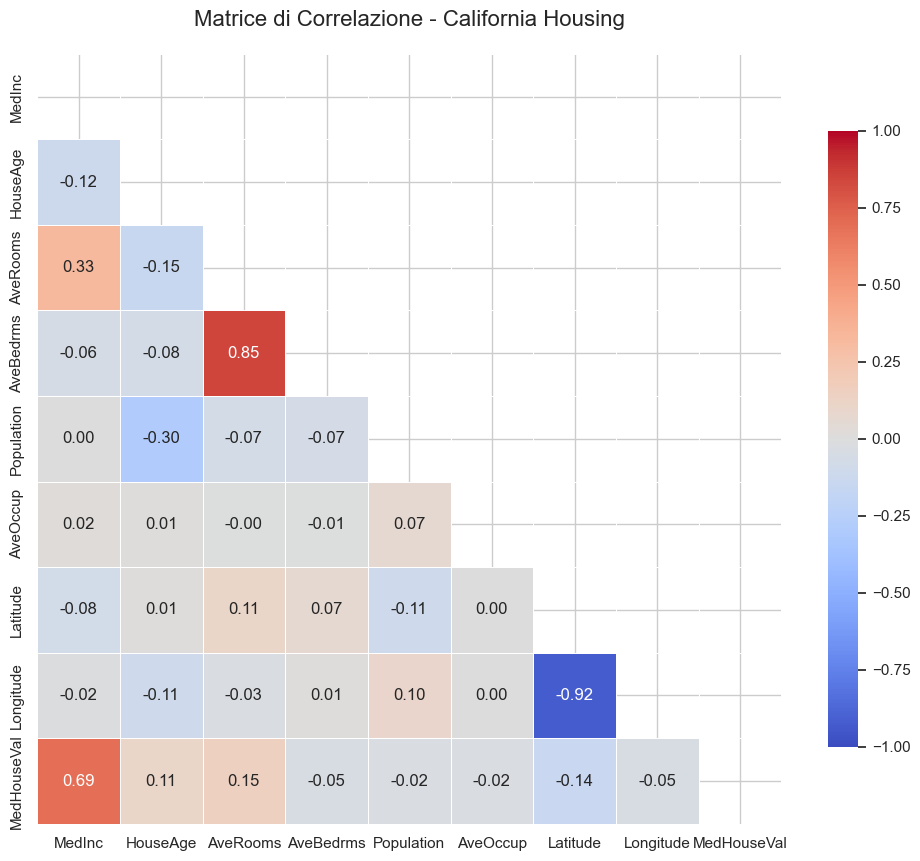

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Calcolo della matrice di correlazione
# Usiamo il metodo di Pearson (default)
corr = df.corr()

# 2. Creazione di una "maschera" per nascondere la parte superiore
# Essendo la matrice speculare, vedere entrambi i lati crea solo confusione visiva
mask = np.triu(np.ones_like(corr, dtype=bool))

# 3. Configurazione del grafico
plt.figure(figsize=(12, 10))

# Disegniamo la heatmap
sns.heatmap(
    corr, 
    mask=mask,          # Nasconde la parte superiore duplicata
    annot=True,         # Scrive i numeri dentro i quadratini
    fmt=".2f",          # Formatta i numeri a 2 decimali
    cmap='coolwarm',    # Colore: rosso (positivo), blu (negativo), bianco (zero)
    vmin=-1, vmax=1,    # Imposta i limiti della scala colorata
    center=0,           # Il centro della scala è lo zero
    linewidths=.5,      # Aggiunge una linea di separazione tra i quadrati
    cbar_kws={"shrink": .8} # Rimpicciolisce la barra dei colori laterale
)

plt.title('Matrice di Correlazione - California Housing', fontsize=16, pad=20)
plt.show()

## Ma se avessimo variabili non correlate linearmente o con tanti outliers?
Possiamo usare la correlazione di Spearman che si basa sui ranghi

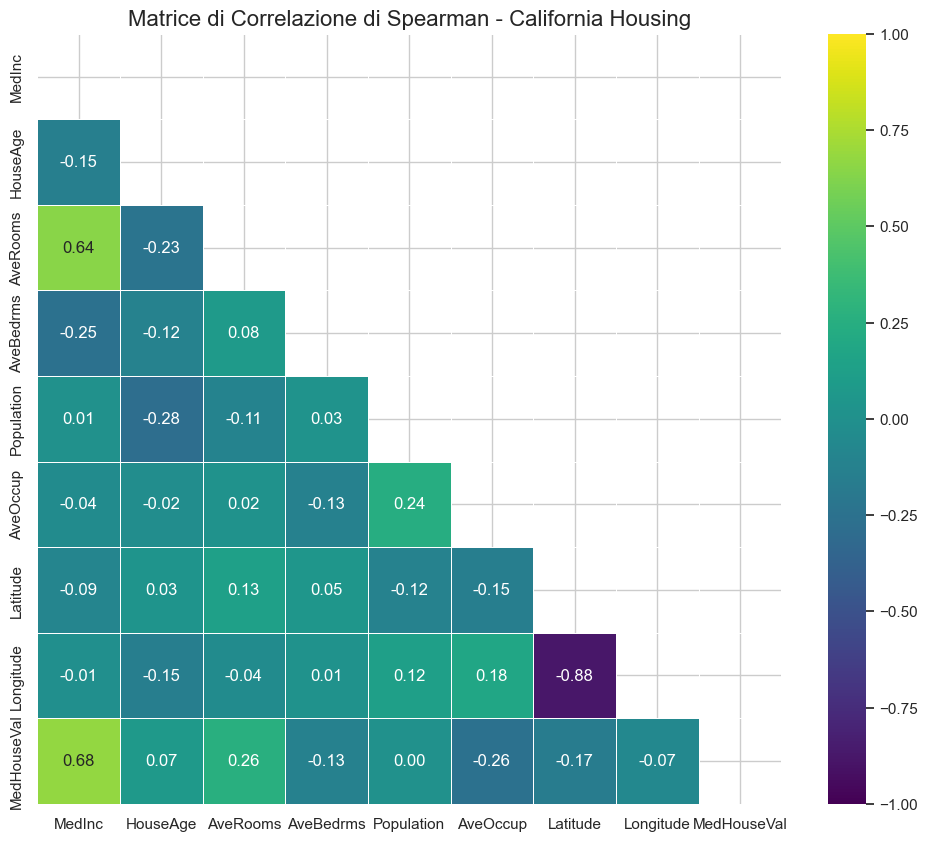

In [101]:
#Calcolo della matrice di Spearman
#Basta cambiare il parametro 'method'
corr_spearman = df.corr(method='spearman')

#Creazione della maschera (per pulizia visiva)
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

#Visualizzazione
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_spearman, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='viridis',    # Cambio colore per distinguerla dalla Pearson
    vmin=-1, vmax=1, 
    center=0,
    linewidths=.5
)

plt.title('Matrice di Correlazione di Spearman - California Housing', fontsize=16)
plt.show()

## Feature Engineering

creare nuove feature come combinazioni o modifiche interessanti di feature esistenti:
- creare raggruppamenti per house age (1 gruppo ogni 5 anni e vedere se ci sono andamenti o pattern, oppure soglie di valore su medInc per definire un ceto basso, medio, alto e vedere se cambiano alcuni pattern)
- Variabili come divizioni di feature esistenti (AveOccup/AveRooms)
- Variabili al quadrato per eventuali relazioni non lineari (da spearman potrei usare ave rooms al quadrato)
- variabili derivate da conoscenza del settore (soprattutto in casi medici, se ho altezza e peso faccio peso/altezza che è un indicatore tecnico medico)

Correlazione di Spearman con il Target (MedHouseVal):
MedHouseVal         1.000000
Income_Class        0.625628
AveRooms_Squared    0.263367
HouseAge_Group      0.075584
Occup_per_Room     -0.399798
Name: MedHouseVal, dtype: float64


C:\Users\elisabetta\AppData\Local\Temp\ipykernel_13324\716166133.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='Income_Class', y='MedHouseVal', palette='viridis')


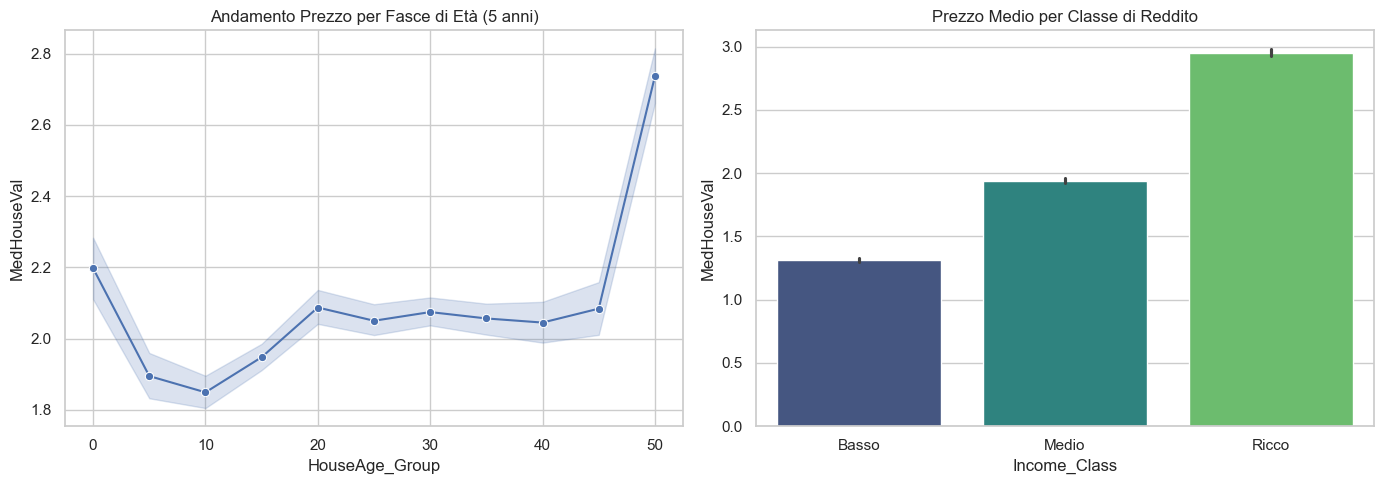

In [102]:
# - FEATURE ENGINEERING -

# A. Raggruppamento HouseAge (ogni 5 anni)
# Creiamo etichette numeriche basate sul limite inferiore del gruppo (0, 5, 10...)
df['HouseAge_Group'] = pd.cut(df['HouseAge'], 
                              bins=range(0, 56, 5), 
                              labels=range(0, 55, 5)).astype(float)

# B. Soglie di valore su MedInc (Ceto Basso, Medio, Ricco)
# Usiamo i quartili per definire le classi in modo bilanciato
df['Income_Class'] = pd.qcut(df['MedInc'], q=3, labels=[1, 2, 3]) 
# 1: Basso, 2: Medio, 3: Ricco (manteniamo numerico per la correlazione)

# C. Rapporto tra feature esistenti (Affollamento per stanza)
# Un valore alto indica potenzialmente zone più povere o popolose
df['Occup_per_Room'] = df['AveOccup'] / df['AveRooms']

# D. Variabile al quadrato (Relazione non lineare per AveRooms)
df['AveRooms_Squared'] = df['AveRooms'] ** 2

# - CALCOLO CORRELAZIONI -

# Selezioniamo le nuove feature e il target
new_features = ['HouseAge_Group', 'Income_Class', 'Occup_per_Room', 'AveRooms_Squared', 'MedHouseVal']
corr_matrix = df[new_features].astype(float).corr(method='spearman')

print("Correlazione di Spearman con il Target (MedHouseVal):")
print(corr_matrix['MedHouseVal'].sort_values(ascending=False))

# - VISUALIZZAZIONE PATTERN -

plt.figure(figsize=(14, 5))

# Plot 1: Andamento Prezzo vs Età Casa (Binned)
plt.subplot(1, 2, 1)
sns.lineplot(data=df, x='HouseAge_Group', y='MedHouseVal', marker='o')
plt.title('Andamento Prezzo per Fasce di Età (5 anni)')

# Plot 2: Prezzo Medio per Classe di Reddito
plt.subplot(1, 2, 2)
sns.barplot(data=df, x='Income_Class', y='MedHouseVal', palette='viridis')
plt.xticks([0, 1, 2], ['Basso', 'Medio', 'Ricco'])
plt.title('Prezzo Medio per Classe di Reddito')

plt.tight_layout()
plt.show()

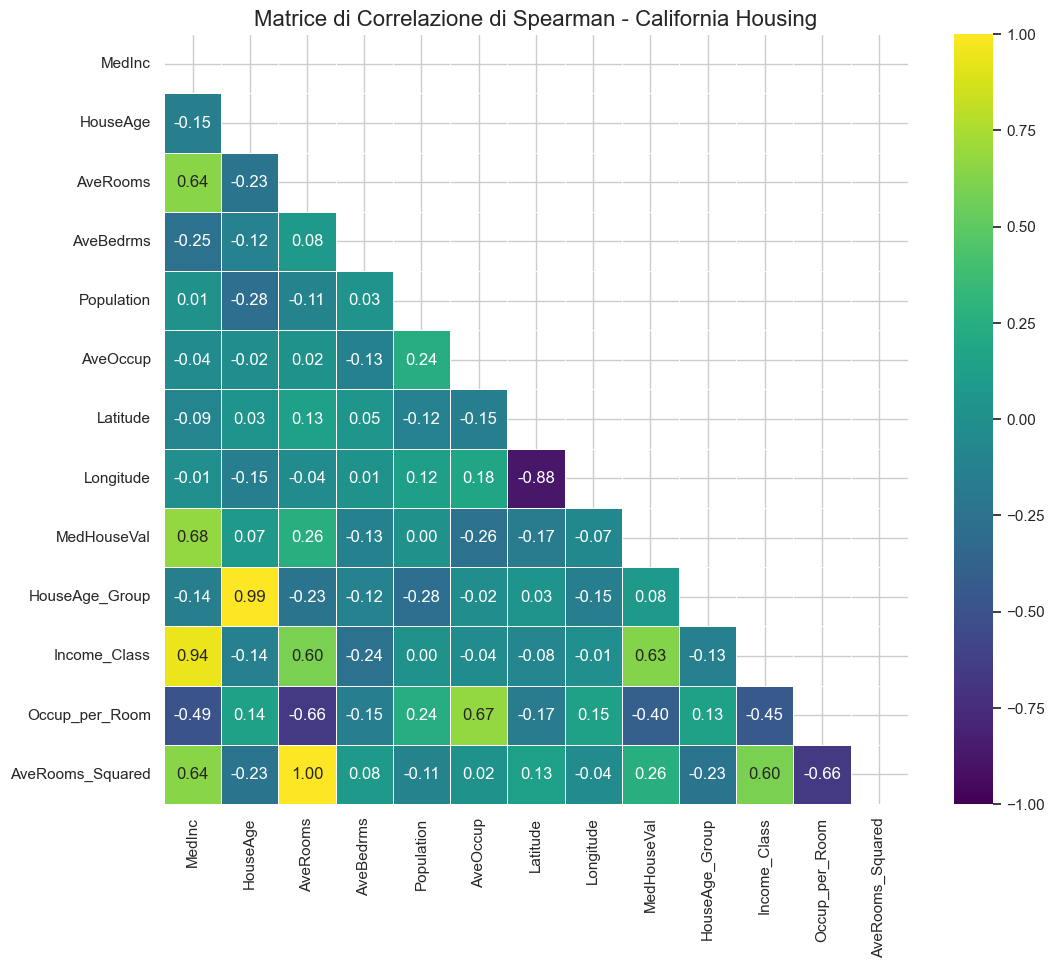

In [103]:
# 1. Calcolo della matrice di Spearman
# Basta cambiare il parametro 'method'
corr_spearman = df.corr(method='spearman')

# 2. Creazione della maschera (per pulizia visiva)
mask = np.triu(np.ones_like(corr_spearman, dtype=bool))

# 3. Visualizzazione
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_spearman, 
    mask=mask, 
    annot=True, 
    fmt=".2f", 
    cmap='viridis',    # Cambio colore per distinguerla dalla Pearson
    vmin=-1, vmax=1, 
    center=0,
    linewidths=.5
)

plt.title('Matrice di Correlazione di Spearman - California Housing', fontsize=16)
plt.show()

## Normalizzazione

Dobbiamo normalizzare i dati per evitare che valori enormi com e 5mln per i prezzi vadano ad anniettare valori più piccoli come il numero di staze per le case.
Se devo minimizzare un errore e cambiando due valori ottengo:
- un errore più basso di 2 punti sul numero di stanze (media 5.5)
- un errore più basso di 1000 euro sul valore di una casa (media 2mln)

Il migliore miglioramento con un approccio relativo è quello sul numero di stanze, ma matematicamente 1000 è meglio di 2, dibbiamo evitare questa confusione nei modelli:

Min Max Scaler: trasforma i dati tra 0 e 1
Stardard Scaler: li trasforma con media 0 e dev stand 1

Tranne rare eccezioni si usa lo stardard scaler.
questo è un esempio di Pipeline di pre-processing dei dati.

### 1. MinMaxScaler (Normalizzazione)

Trasforma i dati in un intervallo fisso, solitamente **[0, 1]**.


$$x_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}}$$

* **Pro:** Mantiene esattamente la relazione tra i dati.
* **Contro:** È **estremamente sensibile agli outlier**. Se hai un solo valore enorme (es. una casa con 100 stanze), schiaccerà tutti gli altri valori vicini allo zero.

### 2. StandardScaler (Standardizzazione)

Trasforma i dati in modo che abbiano **Media = 0** e **Deviazione Standard = 1**.


$$z = \frac{x - \mu}{\sigma}$$

* **Pro:** È più robusto in presenza di outlier rispetto al Min-Max e rende i coefficienti dei modelli lineari più facili da interpretare.
* **Contro:** Non garantisce un range fisso (i valori possono andare oltre -3 o +3).

Tranne rare eccezioni di base si usa sempre lo standardScaler

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.datasets import fetch_california_housing

# 1. Prepariamo i dati
data = fetch_california_housing(as_frame=True)
X = data.frame[['MedInc', 'HouseAge', 'Population']] # Prendiamo 3 variabili con scale diverse

# 2. Inizializziamo gli Scaler
min_max = MinMaxScaler()
standard = StandardScaler()

# 3. Trasformazione
X_minmax = min_max.fit_transform(X)
X_standard = standard.fit_transform(X)

# Creiamo un DataFrame per confrontare i risultati sulla prima riga
comparison = pd.DataFrame({
    'Originale': X.iloc[0],
    'Min-Max [0, 1]': X_minmax[0],
    'Standard (z-score)': X_standard[0]
})

print("Confronto Scaler sulla prima riga del dataset:")
print(comparison)

Confronto Scaler sulla prima riga del dataset:
            Originale  Min-Max [0, 1]  Standard (z-score)
MedInc         8.3252        0.539668            2.344766
HouseAge      41.0000        0.784314            0.982143
Population   322.0000        0.008941           -0.974429
